In [1]:
import astropy
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
from astropy.stats import Events, bayesian_blocks

In [2]:
class ExponentialBlocks_Events(Events):
    
    def anti_N_k(self,N_k):
        x = np.zeros(len(N_k))
        x[-1]=N_k[-1]
        for i in range(len(N_k)-1):
            x[i] = N_k[i]-N_k[i+1]
        return x
    
    def compute_a(self,T_k,N_k,S_k):
        """Computes as instructed by eq. C116 in Scargle (2013).

        Parameters
        ---------
        N_k : array-like
            number of events in blocks in receding order (from last to first)
        T_k : array-like, float
            length of the blocks in decreasing order
        ---------

        Returns
        ---------
        a : array-like
            optimal parameter for each block identified by T_k
        """
        a = np.ones_like(T_k,dtype=float)
        f = 1
        i = 1
        #print(T_k,N_k,S_k)
        #implementation of Newton's method to find optimal a
        while i<100 and np.any(np.abs(f)>1e-8):
            #Q_k defined as in C114 of Scargle (2013)
            Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))
            #f defined as in C109 of Scargle (2013)
            f = (1/a) - T_k*Q_k + S_k
            #f_prime defined as in C113 of Scargle (2013)
            f_prime = -(1/(a*a)) + T_k*T_k*Q_k*(1+Q_k)
            a -= np.divide(f,f_prime)
            #print(i,max(np.abs(f)),a)
            #print(f'a:{a}')
            i += 1
        #print(i,max(np.abs(f)))
        return a
    
    def fitness(self,T_k,N_k):
        #S_k defined as in C110 of Scargle (2013)
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        a = self.compute_a(T_k,N_k,S_k)
        # the log (to have additivity of the blocks) of C105 from Scargle (2013)
        likelihood = N_k * np.log((a*N_k)/(1-np.exp(-a*T_k))) + a*N_k*S_k - N_k
        return np.log(likelihood)
    
    def get_parameters(self,edge_l,edge_r,t,x):
        T_k,N_k,S_k = self.get_T_k_N_k_S_k_from_edges(edge_l,edge_r,t,x)
        a = self.compute_a(T_k,N_k,S_k)
        gamma = np.divide(a*N_k,1-np.exp(-a*T_k))
        return {'a':a[0],'gamma':gamma[0]}

    def get_T_k_N_k_S_k_from_edges(self,edge_l,edge_r,t,x):
        flagStart=0
        flagEnd=0
        t_end_index=0
        for i,t_d in enumerate(t):
            if edge_l<=t_d and t_d<=edge_r:
                if flagStart==0:
                    flagStart=1
                    t_start_index=i
            elif t_d>edge_r and flagEnd==0:
                flagEnd=1
                t_end_index=i
        if t_end_index == 0:
            t_end_index = len(t)
        t_new = t[t_start_index:t_end_index]
        x_new = x[t_start_index:t_end_index]
        #print(t_new)
        #print(x_new)
        edges = np.concatenate([np.array([edge_l]), 0.5 * (t_new[1:] + t_new[:-1]), np.array([edge_r])])
        #print(edges)
        #print(len(edges))
        block_length = t_new[-1] - edges
        #print(block_length)
        T_k = block_length[:-1] - block_length[-1]
        N_k = np.cumsum(x_new[::-1])[::-1]
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        return T_k,N_k,S_k

/tmp/ipykernel_2962/3106553614.py:33: RuntimeWarning: overflow encountered in exp
  Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))
/tmp/ipykernel_2962/3106553614.py:33: RuntimeWarning: invalid value encountered in divide
  Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))


time needed for execution was 0.014724969863891602 seconds
[ 0.   0.5 14. ]
{'a': nan, 'gamma': nan}
{'a': 0.6663024624896873, 'gamma': 21834.774392607025}


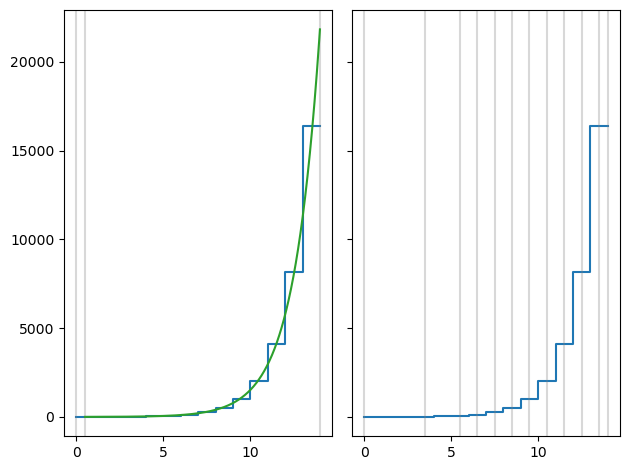

In [3]:
t=np.arange(0,15)
x=np.floor(np.power(2,t))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].step(t, x)
axs[1].step(t, x)
t_start = time.time()
xcoords = bayesian_blocks(t,x,fitness=ExponentialBlocks_Events)
print(f'time needed for execution was {time.time()-t_start} seconds')
print(xcoords)
for xc in xcoords:
    axs[0].axvline(x=xc, color='grey', alpha=0.3)
fitn = ExponentialBlocks_Events()
for i in range(len(xcoords)-1):
    edge_l = xcoords[i]
    edge_r = xcoords[i+1]
    params = fitn.get_parameters(edge_l,edge_r,t,x)
    print(params)
    plot_t = np.linspace(edge_l,edge_r,1000)
    plot_x = params['gamma'] * np.exp(params['a']*(plot_t - edge_r))
    axs[0].plot(plot_t,plot_x)
xcoords = bayesian_blocks(t,x,fitness='events')
for xc in xcoords:
    axs[1].axvline(x=xc, color='grey', alpha=0.3)

/tmp/ipykernel_2962/3106553614.py:33: RuntimeWarning: overflow encountered in exp
  Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))
/tmp/ipykernel_2962/3106553614.py:33: RuntimeWarning: invalid value encountered in divide
  Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))


time needed for execution was 0.0074634552001953125 seconds
[0.  0.5 2. ]
{'a': nan, 'gamma': nan}
{'a': -0.8199554669213064, 'gamma': 1.6934223994907214}


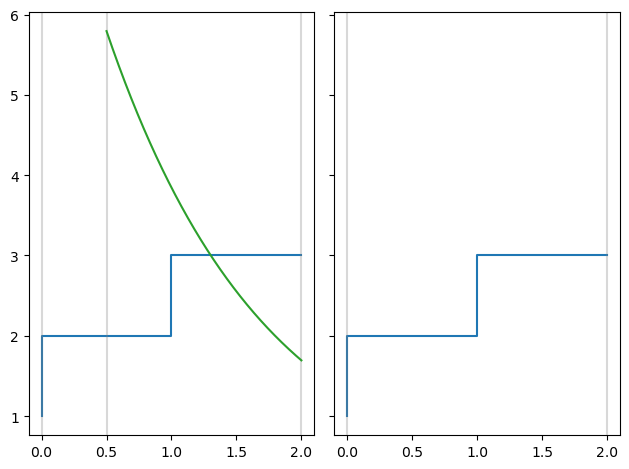

In [4]:
t=np.arange(0,3)
#x=np.floor(np.power(0.9,t)*6000)
x = np.arange(0,3)+1
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].step(t, x)
axs[1].step(t, x)
t_start = time.time()
xcoords = bayesian_blocks(t,x,fitness=ExponentialBlocks_Events)
print(f'time needed for execution was {time.time()-t_start} seconds')
print(xcoords)
for xc in xcoords:
    axs[0].axvline(x=xc, color='grey', alpha=0.3)
fitn = ExponentialBlocks_Events()
for i in range(len(xcoords)-1):
    edge_l = xcoords[i]
    edge_r = xcoords[i+1]
    params = fitn.get_parameters(edge_l,edge_r,t,x)
    print(params)
    plot_t = np.linspace(edge_l,edge_r,1000)
    plot_x = params['gamma'] * np.exp(params['a']*(plot_t - edge_r))
    axs[0].plot(plot_t,plot_x)
xcoords = bayesian_blocks(t,x,fitness='events')
for xc in xcoords:
    axs[1].axvline(x=xc, color='grey', alpha=0.3)